Попробуем обучим Random Forest на уменьшенном количестве признаков с <br>ограниченным количеством данных.<br>
<br>
*В качестве данных возьмем не концентрацию загрязнителей и уже подсчитанные индекс качества воздуха по загрязнителю.*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [4]:
# Скачивание данныъх
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")

# Разбиваем на трейн тест
df_train = data.iloc[:-48]
df_test = data['aqi'].iloc[-48:]
df = data[["CO_index", "PM10_index", "PM2.5_index"]]

INFO:pycodestyle:12:80: E501 line too long (130 > 79 characters)


In [5]:
# Преобразуем исходнные данные
data1 = df_train[["aqi", "CO_index", "PM10_index", "PM2.5_index"]]
df_y = data1[["aqi"]]
df_x = data1[["CO_index", "PM10_index", "PM2.5_index"]]
dfx = DataFrame()
for i in df_x:
    dfx[f'{i}'] = df_x[i].shift(1)
for i in df_x:
    dfx[f'{i}2'] = df_x[i].shift(2)
dfy = DataFrame(df_y)
frames = [dfy, dfx]
results = concat(frames, axis=1)
results = results.dropna()

y = DataFrame(results['aqi'])
x = results
del x['aqi']

In [6]:
# Обучим модель
regr = RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)
regr.fit(x, y)

<ipython-input-6-b42079db1af5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x, y)


RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)

In [8]:
# Выполним предсказание на 48 дней вперед относительно начала тестовой части:
y = DataFrame(df_test)
x = df[-48:].fillna(df_test.mean())
testx = DataFrame()
for day in x:
    testx[f'{day}'] = x[day].shift(1)
for day in x:
    testx[f'{day}2'] = x[day].shift(2)

x = testx
samples = []

for i in range(48):
    # сохраняйте запаздывающей функции для каждого периода
    Xf = np.concatenate([x.iloc[-1, 1:].values.reshape(1, -1),
                         y.iloc[-1].values.reshape(1, 1)], 1)
    forecasts = []

    for t in range(10000):
        tree = regr.estimators_[np.random.randint(len(regr.estimators_))]
        pred = tree.predict(Xf)[0]
        forecasts.append(pred)

        # update lagged features for next period
        Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)

    samples.append(forecasts)

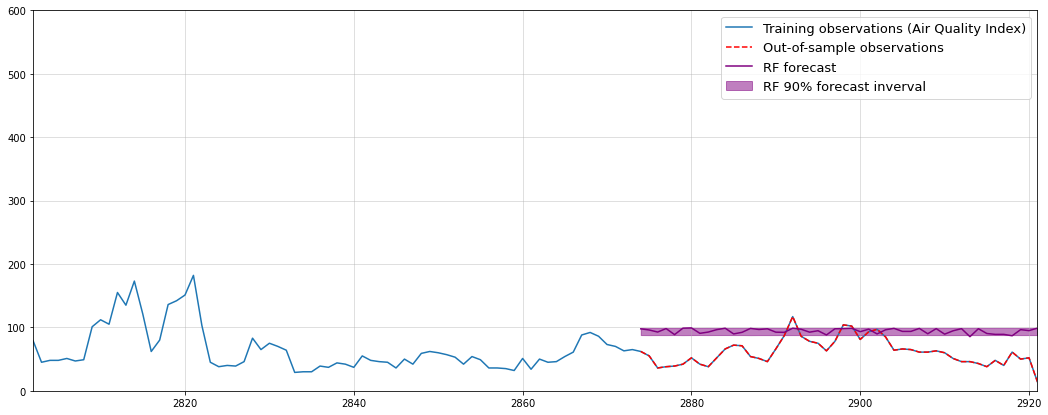

INFO:pycodestyle:11:80: E501 line too long (84 > 79 characters)
INFO:pycodestyle:12:80: E501 line too long (91 > 79 characters)
INFO:pycodestyle:13:80: E501 line too long (96 > 79 characters)
INFO:pycodestyle:15:80: E501 line too long (134 > 79 characters)


In [9]:
# Найдем квантили для формрования доверительного интервала
means_forest = samples
lowers_forest = np.quantile(samples, 0.05, 1)
uppers_forest = np.quantile(samples, 0.95, 1)

# Визуализируем полученные данные
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(data['aqi'].iloc[-120:], label="Training observations (Air Quality Index)")
plt.plot(df_test.iloc[-120:], color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.iloc[-120:].index, means_forest[-1][-48:], color="purple", label="RF forecast")

plt.fill_between(df_test.iloc[-120:].index, lowers_forest, uppers_forest, color="purple", alpha=0.5, label="RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

In [10]:
# Найдем ошибку
mean_absolute_error(df_test.iloc[-120:], means_forest[-1][-48:])

34.28465793898386

### Попробуем обучить лес на ограниченных исходных данных (150 дней)

In [11]:
# Формируем ограниченный тренировочный и тестовый датасет
df_test = data['aqi'].iloc[100:200]
df_train = data.iloc[450:600]

# Преобразуем исходнные данные
data2 = df_train[["aqi", "CO_index", "PM10_index", "PM2.5_index"]]
df_y = data2[["aqi"]]
df_x = data2[["CO_index", "PM10_index", "PM2.5_index"]]
dfx = DataFrame()
for day in df_x:
    dfx[f'{day}'] = df_x[day].shift(1)
for day in df_x:
    dfx[f'{day}2'] = df_x[day].shift(2)
dfy = DataFrame(df_y)
frames = [dfy, dfx]
results = concat(frames, axis=1)
results = results.dropna()

y = DataFrame(results['aqi'])
x = results
del x['aqi']

In [12]:
# Обучим модель
regr = RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)
regr.fit(x, y)

<ipython-input-12-b42079db1af5>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x, y)


RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=123)

In [13]:
# Выполним предсказание на 48 дней вперед относительно начала тестовой части:
y = DataFrame(df_test)
x = df[100:200].fillna(df.mean())
testx = DataFrame()
for day in x:
    testx[f'{day}'] = x[day].shift(1)
for day in x:
    testx[f'{day}2'] = x[day].shift(2)

x = testx
samples = []

for i in range(48):
    # сохраняйте запаздывающей функции для каждого периода
    Xf = np.concatenate([x.iloc[-1, 1:].values.reshape(1, -1),
                         y.iloc[-1].values.reshape(1, 1)], 1)
    forecasts = []

    for t in range(10000):
        tree = regr.estimators_[np.random.randint(len(regr.estimators_))]
        pred = tree.predict(Xf)[0]
        forecasts.append(pred)

        # update lagged features for next period
        Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)

    samples.append(forecasts)

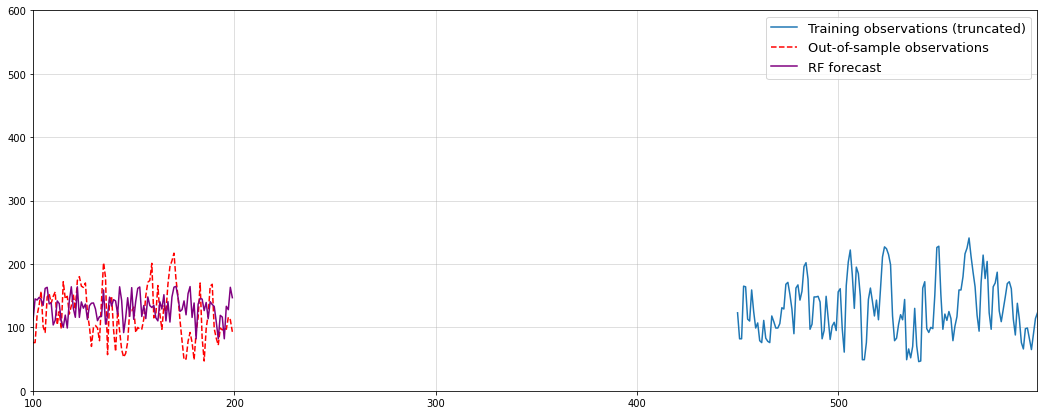

INFO:pycodestyle:13:80: E501 line too long (87 > 79 characters)


In [14]:
# Найдем квантили для формирования доверительного интервала
means_forest = samples
lowers_forest = np.quantile(samples, 0.05, 1)
uppers_forest = np.quantile(samples, 0.95, 1)

# Визуализируем предсказания
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(df_y[:400], label="Training observations (truncated)")
plt.plot(df_test, color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(df_test.index, means_forest[-1][100:200], color="purple", label="RF forecast")

plt.legend(fontsize=13)
plt.margins(x=0)

In [15]:
# Найдем ошибку
mean_absolute_error(df_test, means_forest[-1][100:200])

36.7013174378074

Лучший результат : <br>
 полные данные - MAE 34 <br>
ограниченные данные - MAE 36<br>
В рамках задачи, обучение на "будущих" данных и предсказание прошедших несущественно и допускается.
